In [1]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import os 

Cleaning the data representations to float

In [2]:
df = pd.read_csv('../data/bbdc_student/bbdc_2023_AWI_data_develop_student.csv',delimiter=';',skiprows=[1])
df.dtypes

Datum          object
Uhrzeit        object
SECCI         float64
Temperatur    float64
Salinität     float64
NO2           float64
NO3           float64
NOx            object
dtype: object

In [3]:
char_set = {i for a in df.NOx.dropna() for i in a }
char_set

{' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?'}

In [4]:
empty_brakcets = df.NOx.dropna().str.contains(' ')
df.NOx.dropna()[empty_brakcets]

15587    ? 25
Name: NOx, dtype: object

In [5]:
question_mark = df.NOx.dropna().str.contains('?',regex=False)
df.NOx.dropna()[question_mark]

15587    ? 25
Name: NOx, dtype: object

Set to 25

In [6]:

df.loc[15587,'NOx'] = 25
df.NOx = df.NOx.astype(float)

In [7]:
df

,Datum,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx
0,01.01.1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,02.01.1962,9:00,NaN,4.6,NaN,NaN,NaN,NaN
2,03.01.1962,9:00,NaN,5.1,NaN,NaN,NaN,NaN
3,04.01.1962,9:00,NaN,4.3,NaN,NaN,NaN,NaN
4,05.01.1962,9:00,NaN,5.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
17526,27.12.2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17527,28.12.2010,8:30,1.9,2.9,30.137,0.81,26.10,26.91
17528,29.12.2010,8:15,2.0,2.1,30.273,0.79,26.73,27.52
17529,30.12.2010,8:30,3.0,3.6,31.459,0.64,13.92,14.55


In [8]:
def get_week_day(date):
    date = date.split('.')
    day,month,year = map(int,date)
    
    return datetime.date(year,month,day).weekday()

df['year'] = df.Datum.str.split('.').apply(lambda x: int(x[-1]))
df['day'] = df.Datum.str.split('.').apply(lambda x: int(x[0]))
df['month'] = df.Datum.str.split('.').apply(lambda x: int(x[1]))
df.loc[df.Uhrzeit.str.contains('L') == True, 'Uhrzeit'] = '9:30'
df['hour'] = df.Uhrzeit.apply(lambda x: int(x.split(':')[0]) if pd.notna(x) else pd.NA)
df['minutes'] = df.Uhrzeit.apply(lambda x: int(x.split(':')[1]) if pd.notna(x) else pd.NA)
df['weekday'] = df.Datum.apply(get_week_day)
df['time_as_number'] = df.hour + df.minutes / 60
df.time_as_number = pd.to_numeric(df.time_as_number)
df['missing_values'] = df.isna().sum(axis=1)

An Wochenenden wurde nicht gemessen

In [9]:
df.groupby('weekday')['missing_values'].mean()

weekday
0    1.918164
1    2.328543
2    1.685030
3    2.466454
4    1.915335
5    9.821885
6    9.969249
Name: missing_values, dtype: float64

Es wird nur nach Wochentagen gefragt

In [10]:
eval_df = pd.read_csv('../data/bbdc_student/bbdc_2023_AWI_data_evaluate_skeleton_student.csv',delimiter=';',skiprows=[1])
eval_df['weekday'] = eval_df.Datum.apply(get_week_day)

eval_df['year'] = eval_df.Datum.str.split('.').apply(lambda x: int(x[-1]))
eval_df['day'] = eval_df.Datum.str.split('.').apply(lambda x: int(x[0]))
eval_df['month'] = eval_df.Datum.str.split('.').apply(lambda x: int(x[1]))
eval_df['hour'] = eval_df.Uhrzeit.str.split(':').apply(lambda x: int(x[0]))
eval_df['minutes'] = eval_df.Uhrzeit.str.split(':').apply(lambda x: int(x[1]))
eval_df['time_as_number'] = eval_df.hour + eval_df.minutes / 60
eval_df.weekday.value_counts()

2    191
3    187
1    183
0    180
4    173
Name: weekday, dtype: int64

In [11]:
df = df.set_index('Datum')
eval_df = eval_df.set_index('Datum')

In [12]:
df.year.value_counts().sort_index().value_counts()

365    37
366    11
Name: year, dtype: int64

In [13]:
df.year.unique()

array([1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2005, 2006,
       2007, 2008, 2009, 2010])

In [14]:
df.isna().sum(0)

Uhrzeit            6010
SECCI              8040
Temperatur         6109
Salinität          6299
NO2                7377
NO3                7446
NOx               16077
year                  0
day                   0
month                 0
hour               6010
minutes            6010
weekday               0
time_as_number     6010
missing_values        0
dtype: int64

In [15]:
df.loc[df.weekday < 5].isna().sum()

Uhrzeit            1090
SECCI              3034
Temperatur         1181
Salinität          1336
NO2                2391
NO3                2460
NOx               11069
year                  0
day                   0
month                 0
hour               1090
minutes            1090
weekday               0
time_as_number     1090
missing_values        0
dtype: int64

In [16]:
df.loc[df.Uhrzeit.isna()].missing_values.value_counts()

10    5986
4       22
6        2
Name: missing_values, dtype: int64

In [17]:
(df.loc[df.Uhrzeit.isna()].missing_values < 7)

Datum
01.01.1962    False
07.01.1962    False
10.01.1962    False
11.01.1962    False
12.01.1962    False
              ...  
24.12.2010    False
25.12.2010    False
26.12.2010    False
27.12.2010    False
31.12.2010    False
Name: missing_values, Length: 6010, dtype: bool

In [18]:
sers = (df.loc[df.Uhrzeit.isna()].missing_values < 7)

df.loc[sers.loc[sers].index]

,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx,year,day,month,hour,minutes,weekday,time_as_number,missing_values
Datum,,,,,,,,,,,,,,,
02.09.2005,NaN,6.0,17.0,32.048,0.03,0.88,0.91,2005,2,9,<NA>,<NA>,4,NaN,4
01.11.2007,NaN,4.5,13.2,32.410,0.21,3.87,4.08,2007,1,11,<NA>,<NA>,3,NaN,4
02.11.2007,NaN,4.6,13.2,32.359,0.24,3.48,3.73,2007,2,11,<NA>,<NA>,4,NaN,4
05.11.2007,NaN,3.9,12.5,31.368,0.49,9.01,9.50,2007,5,11,<NA>,<NA>,0,NaN,4
06.11.2007,NaN,1.5,12.2,31.860,0.36,6.64,7.01,2007,6,11,<NA>,<NA>,1,NaN,4
07.11.2007,NaN,0.6,13.3,31.870,0.34,6.24,6.57,2007,7,11,<NA>,<NA>,2,NaN,4
08.11.2007,NaN,0.7,12.2,31.743,0.51,6.54,7.05,2007,8,11,<NA>,<NA>,3,NaN,4
12.11.2007,NaN,0.2,10.1,29.971,0.70,12.49,13.19,2007,12,11,<NA>,<NA>,0,NaN,4
13.11.2007,NaN,1.0,10.0,28.980,0.66,11.33,11.99,2007,13,11,<NA>,<NA>,1,NaN,4


In [19]:
vals = df.loc[df.Uhrzeit.isna()].missing_values < 10
days = vals[vals].index

average_time_per_year = df.groupby('year').time_as_number.mean()

df.loc[days,'time_as_number'] = average_time_per_year.loc[df.loc[days].year].values

for d in days:
    set_to = average_time_per_year.loc[df.loc[d,'year']]
    
    hour = np.floor(set_to)
    minutes = np.round((set_to - hour) * 60).astype(int)
    
    uhrzeit = f'{int(hour)}:{int(minutes)}'
    
    df.loc[d,['hour','minutes','time_as_number','Uhrzeit']] = [hour,minutes, set_to,uhrzeit]
    
df.loc[df.Uhrzeit.isna()].missing_values.value_counts()

10    5986
Name: missing_values, dtype: int64

In [20]:
df.loc[sers.loc[sers].index]

,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx,year,day,month,hour,minutes,weekday,time_as_number,missing_values
Datum,,,,,,,,,,,,,,,
02.09.2005,7:39,6.0,17.0,32.048,0.03,0.88,0.91,2005,2,9,7.0,39,4,7.649331,4
01.11.2007,7:32,4.5,13.2,32.410,0.21,3.87,4.08,2007,1,11,7.0,32,3,7.526636,4
02.11.2007,7:32,4.6,13.2,32.359,0.24,3.48,3.73,2007,2,11,7.0,32,4,7.526636,4
05.11.2007,7:32,3.9,12.5,31.368,0.49,9.01,9.50,2007,5,11,7.0,32,0,7.526636,4
06.11.2007,7:32,1.5,12.2,31.860,0.36,6.64,7.01,2007,6,11,7.0,32,1,7.526636,4
07.11.2007,7:32,0.6,13.3,31.870,0.34,6.24,6.57,2007,7,11,7.0,32,2,7.526636,4
08.11.2007,7:32,0.7,12.2,31.743,0.51,6.54,7.05,2007,8,11,7.0,32,3,7.526636,4
12.11.2007,7:32,0.2,10.1,29.971,0.70,12.49,13.19,2007,12,11,7.0,32,0,7.526636,4
13.11.2007,7:32,1.0,10.0,28.980,0.66,11.33,11.99,2007,13,11,7.0,32,1,7.526636,4


Set missing values to 0

In [21]:
trainings_df = df.loc[(df.weekday < 5) & df.Uhrzeit.notna()]

<Axes: xlabel='year'>

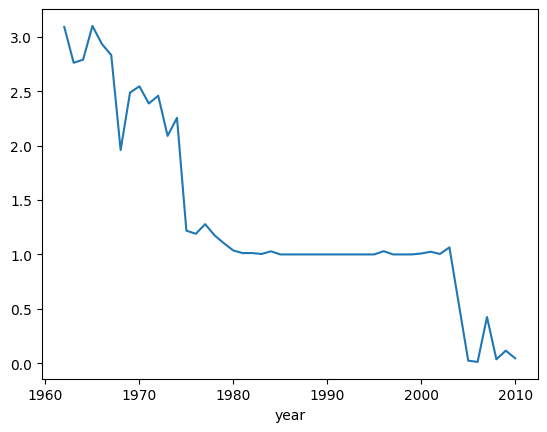

In [22]:
trainings_df.groupby('year').missing_values.mean().plot()

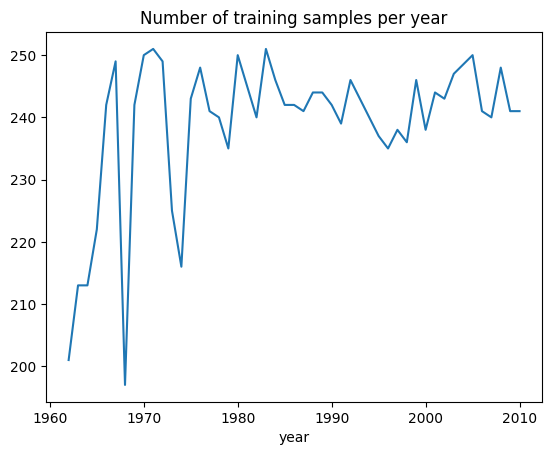

In [23]:
trainings_df.groupby('year').day.count().plot()
plt.title('Number of training samples per year')
plt.show()

<Axes: xlabel='year'>

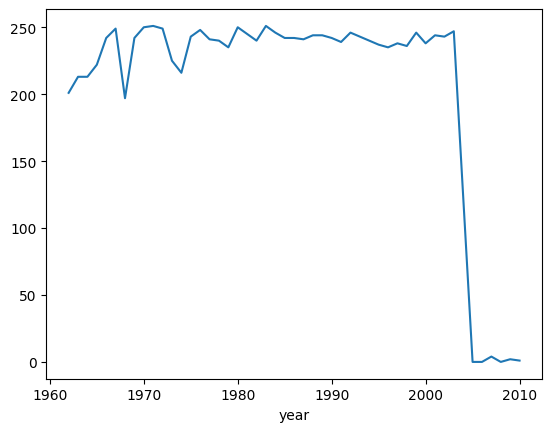

In [24]:
trainings_df.groupby('year')['NOx'].apply(lambda x: x.isna().sum()).plot()

<Axes: xlabel='year'>

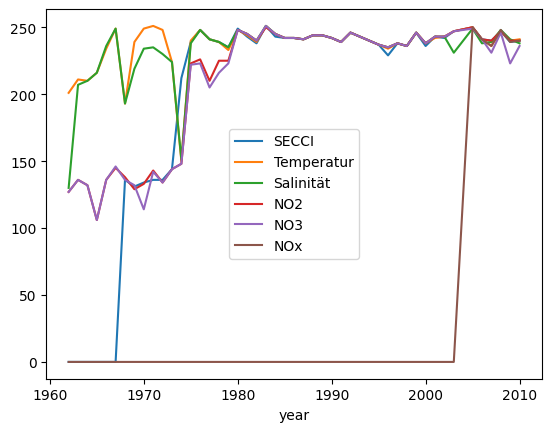

In [25]:
trainings_df.groupby('year')[["SECCI", "Temperatur", "Salinität", "NO2", "NO3","NOx"]].count().plot()

In [26]:
trainings_df[["SECCI", "Temperatur", "Salinität", "NO2", "NO3","NOx"]].corr()

,SECCI,Temperatur,Salinität,NO2,NO3,NOx
SECCI,1.000000,0.324529,0.078943,-0.321012,-0.205303,-0.296605
Temperatur,0.324529,1.000000,-0.139562,-0.447611,-0.488904,-0.678477
Salinität,0.078943,-0.139562,1.000000,0.003427,-0.344130,-0.368230
NO2,-0.321012,-0.447611,0.003427,1.000000,0.203412,0.456309
NO3,-0.205303,-0.488904,-0.344130,0.203412,1.000000,0.997578
NOx,-0.296605,-0.678477,-0.368230,0.456309,0.997578,1.000000


In [27]:
trainings_df.NO3

Datum
02.01.1962      NaN
03.01.1962      NaN
04.01.1962      NaN
05.01.1962      NaN
08.01.1962      NaN
              ...  
21.12.2010    18.85
22.12.2010    12.98
28.12.2010    26.10
29.12.2010    26.73
30.12.2010    13.92
Name: NO3, Length: 11457, dtype: float64

In [28]:
year = trainings_df.groupby('year')['NOx'].count() > 1
year = year[year].index
year

Int64Index([2005, 2006, 2007, 2008, 2009, 2010], dtype='int64', name='year')

In [29]:
after_2004 = trainings_df.query('year > 2004')
after_2004[["NO3","NOx"]].corr()

,NO3,NOx
NO3,1.000000,0.997578
NOx,0.997578,1.000000


In [30]:
after_2004[["NO3","NOx"]].agg(['mean','std'])

,NO3,NOx
mean,10.199025,10.650963
std,10.427513,10.749212


In [31]:
trainings_df[["NO3","NOx"]].agg(['mean','std'])

,NO3,NOx
mean,15.328381,10.650963
std,15.131223,10.749212


In [32]:
after_2004.NO3 - after_2004.NOx

Datum
03.01.2005   -4.42
04.01.2005   -3.26
05.01.2005   -3.54
06.01.2005   -3.17
10.01.2005   -2.32
              ... 
21.12.2010   -0.52
22.12.2010   -0.45
28.12.2010   -0.81
29.12.2010   -0.79
30.12.2010   -0.63
Length: 1461, dtype: float64

In [33]:
NO3_mean = after_2004["NO3"].mean()
NO3_std = after_2004["NO3"].std()
NOx_mean = after_2004["NOx"].mean()
NOx_std = after_2004["NOx"].std()

NO3_as_NOx = (after_2004.NO3 - NO3_mean ) / NO3_std * NOx_std + NOx_mean
(NO3_as_NOx - after_2004.NOx).mean()

-0.1887496213955419

<Axes: xlabel='year'>

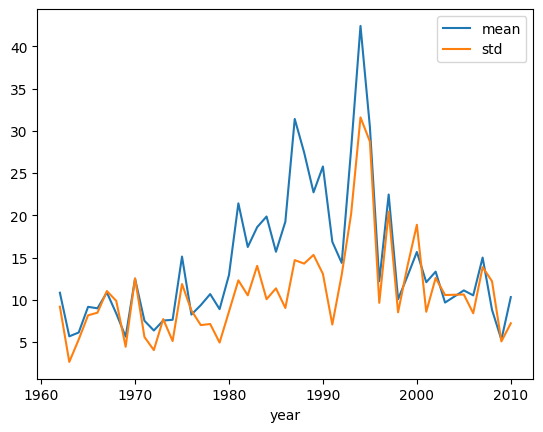

In [34]:
by_year = trainings_df.groupby('year')['NO3'].agg(['mean','std'])

def nox_by_year(row):
    
    m,s = by_year.loc[row.year]
    return (row.NO3 - m ) / s * NOx_std + NOx_mean

by_year_mean = after_2004.apply(nox_by_year,1)
(by_year_mean - after_2004.NOx).mean()

by_year.plot()

<Axes: xlabel='year,month'>

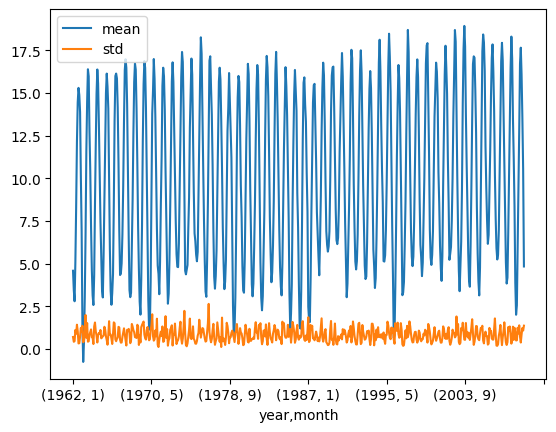

In [35]:
trainings_df.groupby(['year','month']).Temperatur.agg(['mean',np.std]).plot()

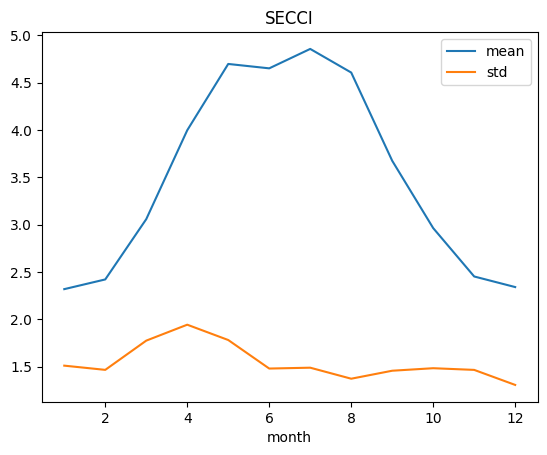

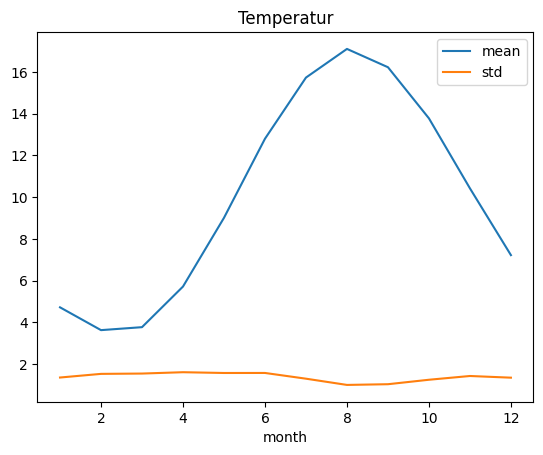

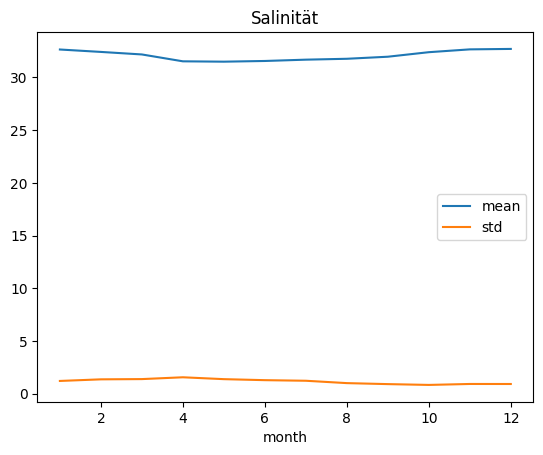

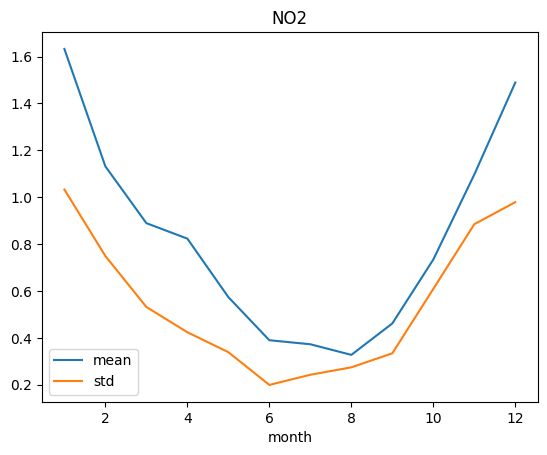

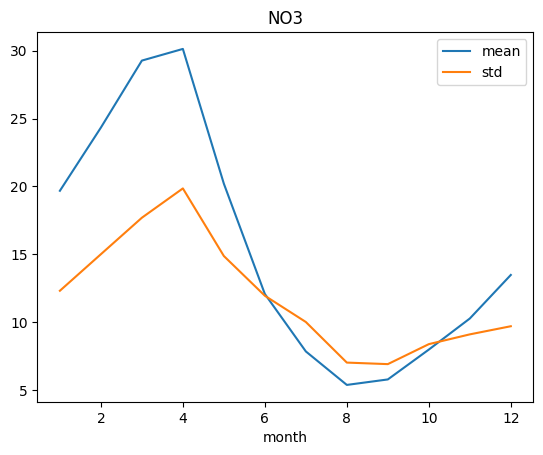

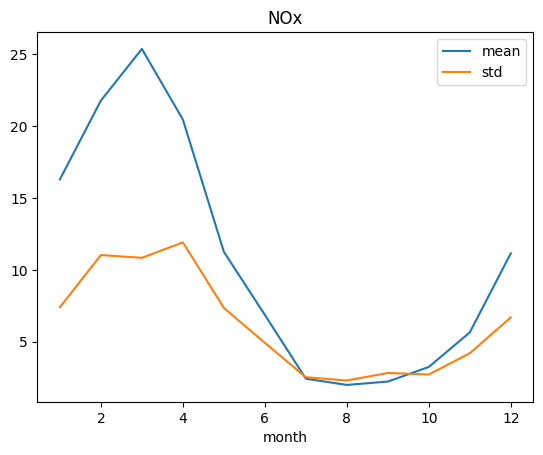

In [36]:
for c in ["SECCI", "Temperatur", "Salinität", "NO2", "NO3","NOx"]:
    
    trainings_df.groupby(['month'])[c].agg(['mean',np.std]).plot()
    plt.title(c)
    plt.show()
    

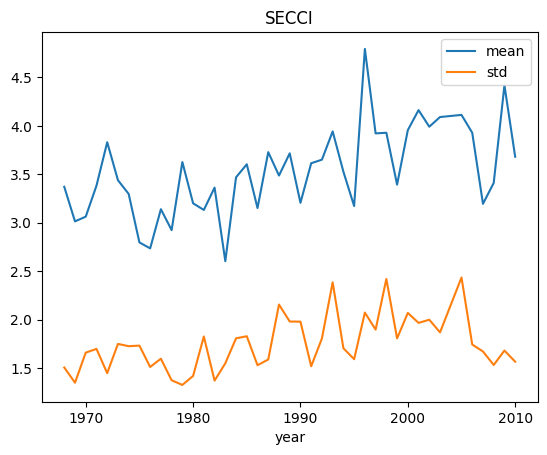

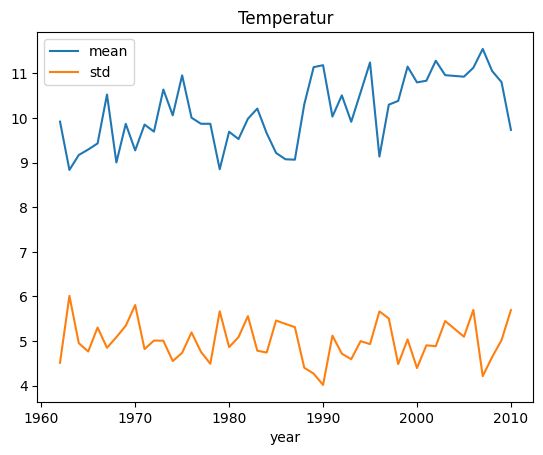

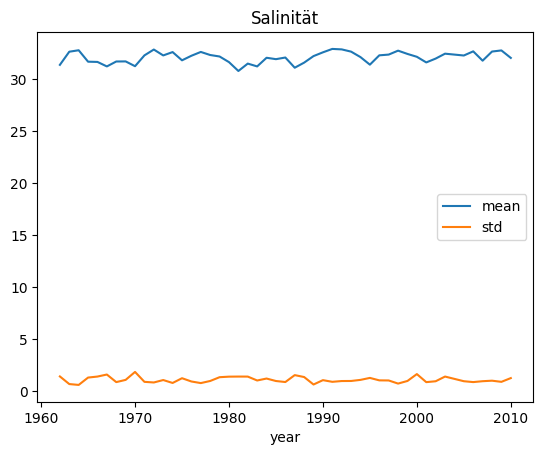

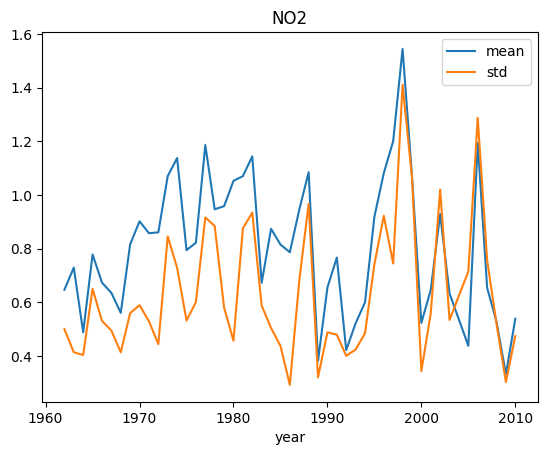

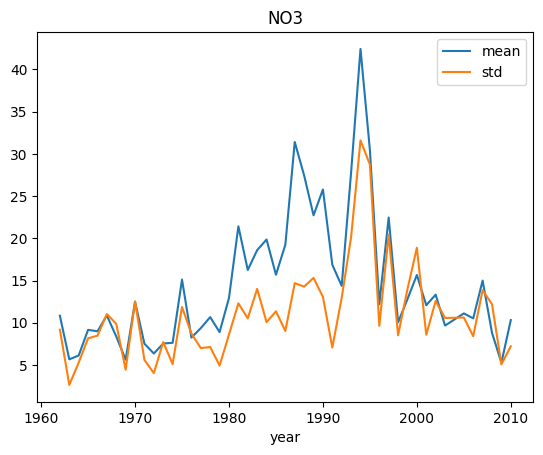

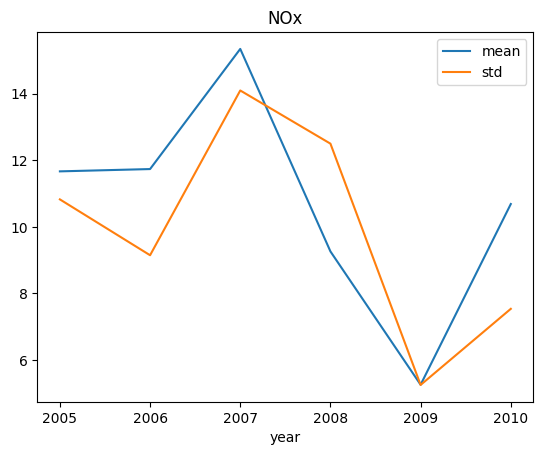

In [37]:
for c in ["SECCI", "Temperatur", "Salinität", "NO2", "NO3","NOx"]:
    
    trainings_df.groupby(['year'])[c].agg(['mean',np.std]).plot()
    plt.title(c)
    plt.show()
    

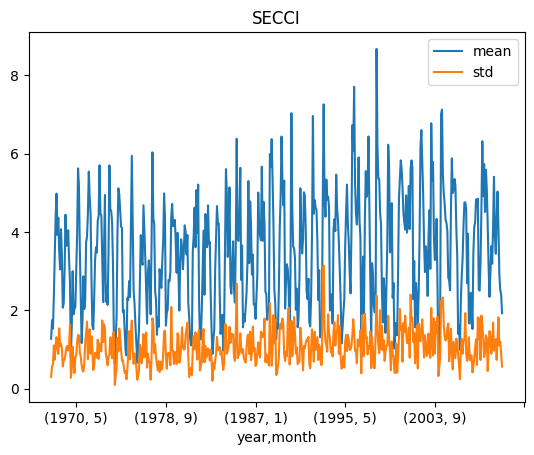

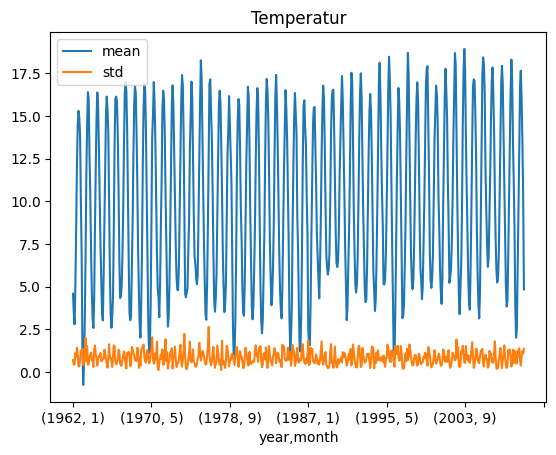

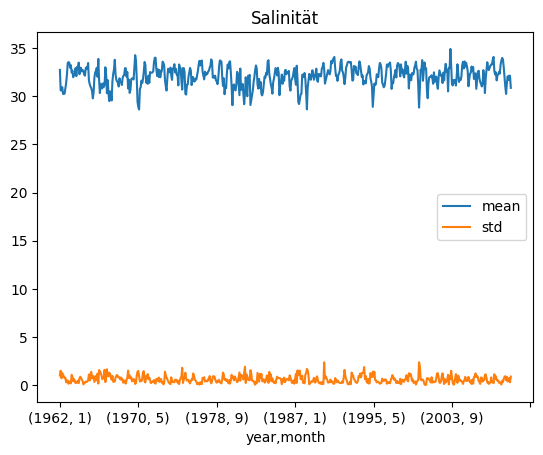

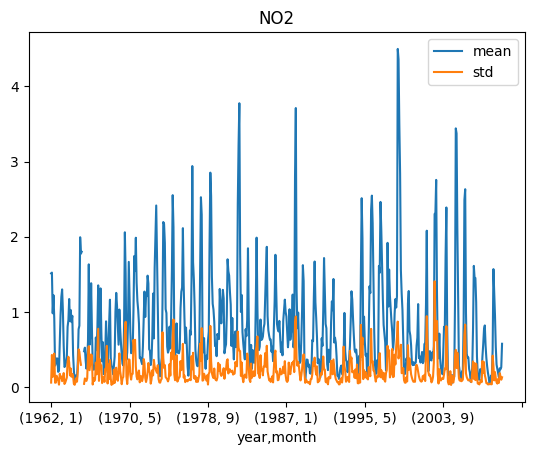

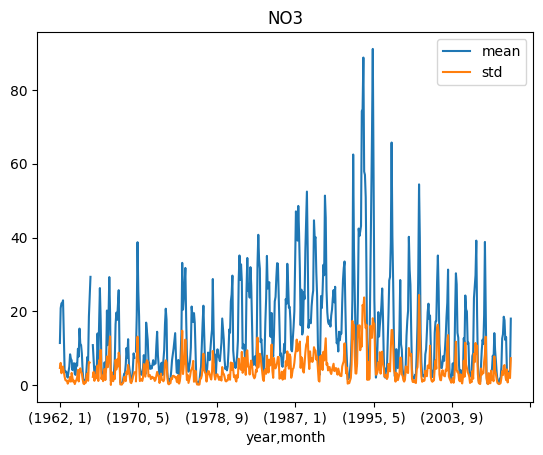

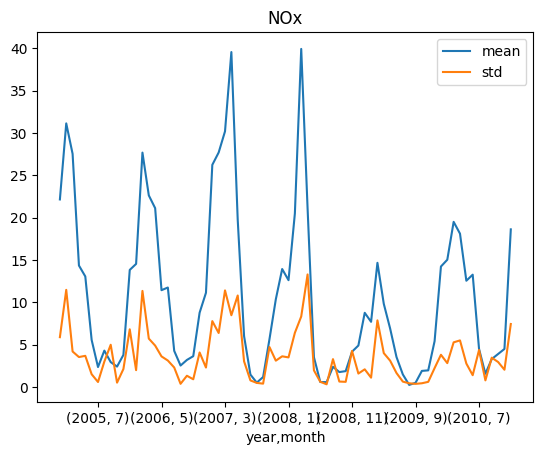

In [38]:
for c in ["SECCI", "Temperatur", "Salinität", "NO2", "NO3","NOx"]:
    
    trainings_df.groupby(['year','month'])[c].agg(['mean',np.std]).plot()
    plt.title(c)
    plt.show()
    

<Axes: xlabel='month'>

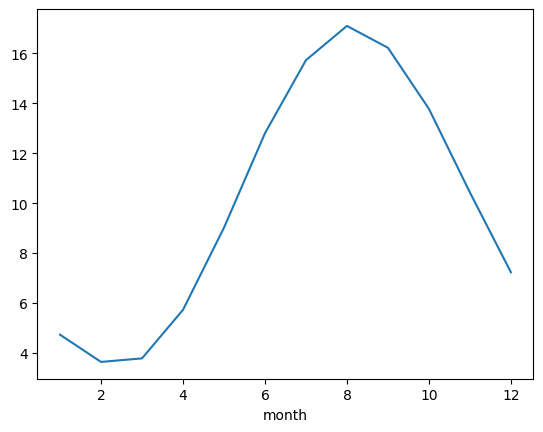

In [39]:
trainings_df.groupby('month').Temperatur.mean().plot()

In [40]:
trainings_df[["SECCI", "Temperatur", "Salinität", "NO2", "NO3","NOx",'month','time_as_number']].corr()

,SECCI,Temperatur,Salinität,NO2,NO3,NOx,month,time_as_number
SECCI,1.000000,0.324529,0.078943,-0.321012,-0.205303,-0.296605,-0.000381,-0.317242
Temperatur,0.324529,1.000000,-0.139562,-0.447611,-0.488904,-0.678477,0.586805,-0.314644
Salinität,0.078943,-0.139562,1.000000,0.003427,-0.344130,-0.368230,0.061772,0.027534
NO2,-0.321012,-0.447611,0.003427,1.000000,0.203412,0.456309,-0.104855,0.242599
NO3,-0.205303,-0.488904,-0.344130,0.203412,1.000000,0.997578,-0.413698,-0.017222
NOx,-0.296605,-0.678477,-0.368230,0.456309,0.997578,1.000000,-0.550218,0.220269
month,-0.000381,0.586805,0.061772,-0.104855,-0.413698,-0.550218,1.000000,-0.060715
time_as_number,-0.317242,-0.314644,0.027534,0.242599,-0.017222,0.220269,-0.060715,1.000000


In [41]:
trainings_df['date_time'] = pd.to_datetime(trainings_df.index + " " + trainings_df.Uhrzeit, format=r'%d.%m.%Y %H:%M')
trainings_df.to_csv('../data/trainings_df.csv')

/tmp/ipykernel_7310/139463820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainings_df['date_time'] = pd.to_datetime(trainings_df.index + " " + trainings_df.Uhrzeit, format=r'%d.%m.%Y %H:%M')
